## 1) Run bash commands to install Java, Spark, and Findspark. 
To use Google Colab, we have to install packages before we start our session. It's quick and easy. The code below uses bash commands to install Apache Spark 2.4.7, Java 8, and Findspark. (Note: This is an older version of Spark that works well with my setup, you can use newer versions like 3.0.0)

In [1]:
!sudo apt update
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q https://downloads.apache.org/spark/spark-2.4.7/spark-2.4.7-bin-hadoop2.7.tgz
!tar xf spark-2.4.7-bin-hadoop2.7.tgz
!pip install -q findspark

Ign:1 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Ign:2 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:3 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release
Hit:4 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Hit:5 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease
Get:7 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Hit:9 http://archive.ubuntu.com/ubuntu bionic InRelease
Get:10 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Hit:11 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease
Hit:12 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Get:13 http://archive.ubuntu.com/ubuntu bionic-backports InRelease [74.6 kB]
Hit:14 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu bionic InRelease
Hit:15 http://ppa.launchpad.net/gra

## 2) Set environment variables
This code sets up the locations of your Java and Spark installs.

In [2]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-1.8.0-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-2.4.7-bin-hadoop2.7"

## 3) Start Findspark
Findspark is a library that let's Python easily find Spark. This just makes our lives easier.

In [3]:
import findspark
findspark.init()

## 4) Make a SparkSession
This is the big step that starts the PySpark session in Google Colab. This will create a session called 'spark' on the Google server.

In [4]:
# import necessary libraries
from pyspark import SparkContext
from pyspark.sql import SparkSession, Window, Row
from pyspark.sql.functions import *
from pyspark.sql.types import *
import matplotlib.pyplot as plt


sc = SparkContext('local[*]')
spark = SparkSession(sc)

# 6) Upload files
You might now want to put some datafiles or libraries into your project.
The code below will give you a form for inserting it.  You can find the files in the folder to the left after upload.  Then they are ready for import or read.

In [5]:
from google.colab import files
files.upload()

{}

In [11]:
def load_dataframe(filename):
    df = spark.read.format('csv').options(header='true').load(filename)
    return df

#creating a dataframe
df_matches = load_dataframe('./drive/MyDrive/Matches.csv')

In [12]:
df_matches.limit(5).show()

+--------+---+------+----------+-------------+--------------+----+----+---+
|Match_ID|Div|Season|      Date|     HomeTeam|      AwayTeam|FTHG|FTAG|FTR|
+--------+---+------+----------+-------------+--------------+----+----+---+
|       1| D2|  2009|2010-04-04|   Oberhausen|Kaiserslautern|   2|   1|  H|
|       2| D2|  2009|2009-11-01|  Munich 1860|Kaiserslautern|   0|   1|  A|
|       3| D2|  2009|2009-10-04|Frankfurt FSV|Kaiserslautern|   1|   1|  D|
|       4| D2|  2009|2010-02-21|Frankfurt FSV|     Karlsruhe|   2|   1|  H|
|       5| D2|  2009|2009-12-06|        Ahlen|     Karlsruhe|   1|   3|  A|
+--------+---+------+----------+-------------+--------------+----+----+---+



In [13]:
#lets rename some of the columns
old_cols = df_matches.columns[-3:]
new_cols = ["HomeTeamGoals", "AwayTeamGoals", "FinalResult"]
old_new_cols = [*zip(old_cols, new_cols)]
for old_col, new_col in old_new_cols:
    df_matches = df_matches.withColumnRenamed(old_col, new_col)

In [14]:
df_matches.limit(5).show()

+--------+---+------+----------+-------------+--------------+-------------+-------------+-----------+
|Match_ID|Div|Season|      Date|     HomeTeam|      AwayTeam|HomeTeamGoals|AwayTeamGoals|FinalResult|
+--------+---+------+----------+-------------+--------------+-------------+-------------+-----------+
|       1| D2|  2009|2010-04-04|   Oberhausen|Kaiserslautern|            2|            1|          H|
|       2| D2|  2009|2009-11-01|  Munich 1860|Kaiserslautern|            0|            1|          A|
|       3| D2|  2009|2009-10-04|Frankfurt FSV|Kaiserslautern|            1|            1|          D|
|       4| D2|  2009|2010-02-21|Frankfurt FSV|     Karlsruhe|            2|            1|          H|
|       5| D2|  2009|2009-12-06|        Ahlen|     Karlsruhe|            1|            3|          A|
+--------+---+------+----------+-------------+--------------+-------------+-------------+-----------+



# Q1) Who are the winners of the D1 division in the Germany Football Association (Bundesliga) between 2000–2010?

To answer this question, it requires a bit of data manipulation. I have chosen the most straight forward approach so it’s easier to follow. The design is to aggregate the home and away game results separately creating two dataframes: home and away.

In [23]:
df_matches = df_matches \
    .withColumn('HomeTeamWin', when(col('FinalResult') == 'H', 1).otherwise(0)) \
    .withColumn('AwayTeamWin', when(col('FinalResult') == 'A', 1).otherwise(0)) \
    .withColumn('GameTie', when(col('FinalResult') == 'D', 1).otherwise(0))


#bundesliga is a D1 division and we are interested in season <= 2010 and >= 2000
bundesliga = df_matches \
                    .filter((col('Season') >= 2000) & 
                            (col('Season') <= 2010) & 
                            (col('Div') == 'D1'))

# home team features
home = bundesliga.groupby('Season', 'HomeTeam') \
       .agg(sum('HomeTeamWin').alias('TotalHomeWin'),
            sum('AwayTeamWin').alias('TotalHomeLoss'),
            sum('GameTie').alias('TotalHomeTie'),
            sum('HomeTeamGoals').alias('HomeScoredGoals'),
            sum('AwayTeamGoals').alias('HomeAgainstGoals')) \
       .withColumnRenamed('HomeTeam', 'Team')

#away game features 
away =  bundesliga.groupby('Season', 'AwayTeam') \
       .agg(sum('AwayTeamWin').alias('TotalAwayWin'),
            sum('HomeTeamWin').alias('TotalAwayLoss'),
            sum('GameTie').alias('TotalAwayTie'),
            sum('AwayTeamGoals').alias('AwayScoredGoals'),
            sum('HomeTeamGoals').alias('AwayAgainstGoals'))  \
       .withColumnRenamed('AwayTeam', 'Team')

Then, inner join them on ‘Team’ and ‘Season’ fields to create a single dataframe containing game level aggregation: table. After that, I use a basic window function to further aggregate game statistics on season level and rank them based on winning percentage and goal differentials. The reason why I added goal differentials is because it’s used as a tie-breaker in soccer.

In [27]:
#season features
window = ['Season']
window = Window.partitionBy(window).orderBy(col('WinPct').desc(), col('GoalDifferentials').desc())

# join the home and away together again on the team and season
table = home.join(away, ['Team', 'Season'],  'inner') \
    .withColumn('GoalsScored', col('HomeScoredGoals') + col('AwayScoredGoals')) \
    .withColumn('GoalsAgainst', col('HomeAgainstGoals') + col('AwayAgainstGoals')) \
    .withColumn('GoalDifferentials', col('GoalsScored') - col('GoalsAgainst')) \
    .withColumn('Win', col('TotalHomeWin') + col('TotalAwayWin')) \
    .withColumn('Loss', col('TotalHomeLoss') + col('TotalAwayLoss')) \
    .withColumn('Tie', col('TotalHomeTie') + col('TotalAwayTie')) \
    .withColumn('WinPct', round((100* col('Win')/(col('Win') + col('Loss') + col('Tie'))), 2)) \
    .drop('HomeScoredGoals', 'AwayScoredGoals', 'HomeAgainstGoals', 'AwayAgainstGoals') \
    .drop('TotalHomeWin', 'TotalAwayWin', 'TotalHomeLoss', 'TotalAwayLoss', 'TotalHomeTie', 'TotalAwayTie') \
    .withColumn('TeamPosition', rank().over(window)) 



In [28]:
table = table.filter(col('TeamPosition') == 1).orderBy(asc('Season'))
table.show() # no limit just shows the whole table

+-------------+------+-----------+------------+-----------------+---+----+---+------+------------+
|         Team|Season|GoalsScored|GoalsAgainst|GoalDifferentials|Win|Loss|Tie|WinPct|TeamPosition|
+-------------+------+-----------+------------+-----------------+---+----+---+------+------------+
|Bayern Munich|  2000|       62.0|        37.0|             25.0| 19|   9|  6| 55.88|           1|
|   Leverkusen|  2001|       77.0|        38.0|             39.0| 21|   7|  6| 61.76|           1|
|Bayern Munich|  2002|       70.0|        25.0|             45.0| 23|   5|  6| 67.65|           1|
|Werder Bremen|  2003|       79.0|        38.0|             41.0| 22|   4|  8| 64.71|           1|
|Bayern Munich|  2004|       75.0|        33.0|             42.0| 24|   5|  5| 70.59|           1|
|Bayern Munich|  2005|       67.0|        32.0|             35.0| 22|   3|  9| 64.71|           1|
|    Stuttgart|  2006|       61.0|        37.0|             24.0| 21|   6|  7| 61.76|           1|
|Bayern Mu

These are my champions from 2000 to 2010.  Bayern won 6 times.

# Does Octoberfest affect the number of goals?

In [31]:

oktoberfest = df_matches \
                .filter(col('Div') == 'D1') \
                .filter((col('Season') >= 2000) &(col('Season') <= 2010)) \
                .withColumn('Month', month(col('Date'))) \
                .groupby('Month') \
                .agg(sum(col('HomeTeamGoals') + col('AwayTeamGoals')).alias('Goals'),
                     sum('GameTie').alias('GameTie'),
                     count(col('FinalResult')).alias('Total')) \
                .withColumn('Goals_to_games_ratio', round(col('Goals')/col('Total'), 1)) \
                .withColumn('GameTie_to_games_ratio', round(col('GameTie')/col('Total'), 1))

oktoberfest.show()


+-----+------+-------+-----+--------------------+----------------------+
|Month| Goals|GameTie|Total|Goals_to_games_ratio|GameTie_to_games_ratio|
+-----+------+-------+-----+--------------------+----------------------+
|   12| 813.0|     91|  290|                 2.8|                   0.3|
|    1| 386.0|     27|  140|                 2.8|                   0.2|
|    3|1076.0|     96|  386|                 2.8|                   0.2|
|    5| 993.0|     65|  308|                 3.2|                   0.2|
|    9|1027.0|     91|  364|                 2.8|                   0.3|
|    4|1138.0|     90|  416|                 2.7|                   0.2|
|    8| 871.0|     82|  298|                 2.9|                   0.3|
|    7|  14.0|      2|    8|                 1.8|                   0.3|
|   10|1036.0|     81|  354|                 2.9|                   0.2|
|   11|1160.0|     92|  387|                 3.0|                   0.2|
|    2|1108.0|    110|  415|                 2.7|  

+-----+------+-------+-----+--------------------+----------------------+
|Month|Goals |GameTie|Total|Goals_to_games_ratio|GameTie_to_games_ratio|
+-----+------+-------+-----+--------------------+----------------------+
|1    |386.0 |27     |140  |2.8                 |0.2                   |
|2    |1108.0|110    |415  |2.7                 |0.3                   |
|3    |1076.0|96     |386  |2.8                 |0.2                   |
|4    |1138.0|90     |416  |2.7                 |0.2                   |
|5    |993.0 |65     |308  |3.2                 |0.2                   |
|7    |14.0  |2      |8    |1.8                 |0.3                   |
|8    |871.0 |82     |298  |2.9                 |0.3                   |
|9    |1027.0|91     |364  |2.8                 |0.3                   |
|10   |1036.0|81     |354  |2.9                 |0.2                   |
|11   |1160.0|92     |387  |3.0                 |0.2                   |
|12   |813.0 |91     |290  |2.8                 |0.

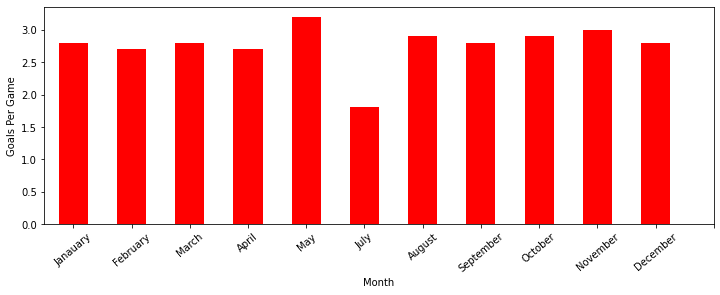

In [46]:
oktoberfest = oktoberfest.sort("Month")
oktoberfest.show(truncate=False)

# can't plot in pyspark, so we bring it to pandas
oktoberfest_df = oktoberfest.toPandas()

# oktoberfest_df = oktoberfest_df.sort_values('Month')
#oktoberfest_df['Month'] = [calendar.month_name[val] for val in oktoberfest_df.Month.tolist()]
months = {1:'Janauary',
		2:'February',
		3:'March',
		4:'April',
		5:'May',
		6:'June',
		7:'July',
		8:'August',
		9:'September',
		10:'October',
		11:'November',
		12:'December'}

oktoberfest_df['MonthName'] = oktoberfest_df["Month"].map(months)
oktoberfest_df.set_index('Month', drop=True, inplace=True)
oktoberfest_df['Goals_to_games_ratio'].plot.bar(rot=0, color='red', figsize=(12, 4))
plt.xticks([x for x in range(12)], oktoberfest_df['MonthName'], rotation=40)
plt.ylabel('Goals Per Game')
plt.show()

There is no June.  I'm not familiar with German soccer.